# 영화 리뷰를 사용한 텍스트 분류

이 튜토리얼은 디스크에 저장된 일반 텍스트 파일에서 시작하는 텍스트 분류를 보여줍니다. IMDB 데이터세트에 대한 감정 분석을 수행하도록 이진 분류기를 훈련합니다. 노트북의 마지막에는 스택 오버플로에서 프로그래밍 질문에 대한 태그를 예측하도록 다중 클래스 분류기를 훈련하는 연습을 시도해볼 수 있습니다.


Test
 - tf 2.19, keras 3.18


In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

import tensorflow as tf
import keras

2025-07-25 07:47:31.095185: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 07:47:31.252523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753397251.390236  142652 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753397251.424811  142652 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753397251.570715  142652 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
print(tf.__version__)

2.19.0


## 감정 분석 (긍정-부정 분류)

이 노트북은 리뷰 텍스트를 사용하여 영화 리뷰를 *긍정적* 또는 *부정적*으로 분류합니다. 중요하고 널리 적용 가능한 머신러닝 문제인 *이진* 분류의 예입니다.

[IMDB 데이터세트](https://ai.stanford.edu/~amaas/data/sentiment/)에는 [인터넷 영화 데이터베이스](https://www.imdb.com/)에서 가져온 50,000개의 영화 리뷰 텍스트가 포함되어 있습니다. 훈련용 리뷰 25,000개와 테스트용 리뷰 25,000개로 나뉩니다. 훈련 및 테스트 세트는 *균형을 이룹니다*. 즉, 동일한 수의 긍정적인 리뷰와 부정적인 리뷰가 포함되어 있습니다.


### 데이터세트 다운로드 및 탐색하기

데이터 세트를 다운로드하여 추출한 다음 디렉터리 구조를 살펴보겠습니다.

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"




In [4]:
dataset, os.path.dirname(dataset)

('data/aclImdb_v1', 'data')

In [5]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb_v1/aclImdb')

['imdbEr.txt', 'train', 'test', 'README', 'imdb.vocab']

['neg',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_unsup.txt',
 'pos',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsup']

`aclImdb/train/pos` 및 `aclImdb/train/neg` 디렉토리에는 각각 단일 영화를 리뷰한 많은 텍스트 파일이 포함되어 있습니다. 그 중 하나를 살펴보겠습니다.

In [ ]:
# pos/1181_9.txt




Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## 데이터세트 로드하기

디스크에서 데이터를 로드하고 훈련에 적합한 형식으로 준비합니다. 이를 위해 다음과 같은 디렉토리 구조로 데이터를 준비하면 
[text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) 유틸리티로 데이터 세트를 탑재할 수 있습니다.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

이진 분류를 위한 데이터세트를 준비하려면 디스크에 `class_a` 및 `class_b`에 해당하는 두 개의 폴더로 구성한다
 - 여기서 `aclImdb/train/pos` 및 `aclImdb/train/neg` 는 긍정적 영화 리뷰와 부정적 영화 리뷰 폴더이다. 

IMDB 데이터세트에는 추가 폴더가 포함되어 있으므로 이 유틸리티를 사용하기 전에 제거합니다.

In [ ]:
# train dir



['neg',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_unsup.txt',
 'pos',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsup']

In [ ]:
# test dir




['neg', 'urls_neg.txt', 'pos', 'urls_pos.txt', 'labeledBow.feat']

In [11]:
# unsup 디렉토리 삭제
remove_dir = os.path.join(train_dir, 'unsup')
try:
    shutil.rmtree(remove_dir)
except FileNotFoundError as e:
    print(e)

['neg',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_unsup.txt',
 'pos',
 'urls_pos.txt',
 'labeledBow.feat']

In [ ]:
# pos 디렉토리의 파일 목록



['3567_8.txt',
 '2602_10.txt',
 '10202_10.txt',
 '3466_7.txt',
 '4088_7.txt',
 '4163_9.txt',
 '8563_10.txt',
 '5428_10.txt',
 '8777_10.txt',
 '5465_8.txt',
 '10420_10.txt',
 '2585_7.txt',
 '748_9.txt',
 '739_7.txt',
 '2366_7.txt',
 '592_10.txt',
 '8392_8.txt',
 '6087_9.txt',
 '4975_8.txt',
 '7254_10.txt',
 '10467_10.txt',
 '4610_10.txt',
 '11634_9.txt',
 '8580_9.txt',
 '9849_9.txt',
 '8485_8.txt',
 '5240_7.txt',
 '6400_9.txt',
 '10086_7.txt',
 '8373_9.txt',
 '5871_9.txt',
 '3228_7.txt',
 '972_9.txt',
 '10447_10.txt',
 '12113_8.txt',
 '6939_9.txt',
 '6674_9.txt',
 '9257_7.txt',
 '10410_10.txt',
 '6342_10.txt',
 '1850_10.txt',
 '2221_8.txt',
 '12124_8.txt',
 '8808_9.txt',
 '9666_10.txt',
 '6077_9.txt',
 '7293_10.txt',
 '2719_10.txt',
 '11037_8.txt',
 '3710_9.txt',
 '7101_10.txt',
 '1242_9.txt',
 '4080_10.txt',
 '12089_10.txt',
 '7951_10.txt',
 '1428_7.txt',
 '1968_8.txt',
 '2983_7.txt',
 '6048_9.txt',
 '5575_8.txt',
 '989_9.txt',
 '8433_9.txt',
 '9655_10.txt',
 '6406_9.txt',
 '443_10.txt

다음으로 `text_dataset_from_directory` 유틸리티를 사용하여 레이블이 지정된 `tf.data.Dataset`를 만듭니다. [tf.data](https://www.tensorflow.org/guide/data)는 데이터 작업을 위한 강력한 도구 모음입니다.

머신러닝 실험을 실행할 때 데이터세트를 train, validation 및 test의 세 부분으로 나누는 것이 가장 좋습니다.


### train 세트

IMDB 데이터세트는 이미 훈련과 테스트로 나누어져 있지만 검증 세트가 부족합니다. 아래 `validation_split` 인수를 사용하여 훈련 데이터를 80:20으로 분할하여 검증 세트를 생성해 보겠습니다.

In [14]:
train_dir

'data/aclImdb_v1/aclImdb/train'

In [ ]:
batch_size = 32
seed = 50





Found 25000 files belonging to 2 classes.
Using 20000 files for training.


I0000 00:00:1753397314.406427  142652 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2051 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


위에서 볼 수 있듯이 training 폴더에는 25,000개의 예제가 있으며 그 중 80%(또는 20,000개)를 훈련에 사용할 것입니다. 

`tf.data`를 처음 사용하는 경우 데이터세트를 반복하고 다음과 같이 몇 가지 예를 출력할 수도 있습니다.

In [16]:
# take 로 첫번째 요소 확인
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'Gee, what a heck of a movie!... I said I wanted to become a specialist in bad movies from all decades, so I decided to start by this one. It was a pretty adequate choice. I entered this adventure to find some lost gems and uncomprehended masterpieces, but I didn\'t see anything of the sort in this pastel-coloured mess. I haven\'t really watched many bad films before, but I\'ve got the feeling this is what\'s called "so bad that\'s good", probably because it is so unintentionally damn funny! First of all, there are the inaccuracies. There are plot-related inaccuracies, physical inaccuracies, and also psychological inaccuracies. The latter in particular are as insane as Van Damme\'s ass cheeks inside that blue spandex. Extremely tacky lines exist too and I won\'t even start to talk about some of the hilarious action moves. There isn\'t exactly bad acting from everyone involved in that hot mess of a movie, except in one particular case. Geoffrey Lewis looks completely pathetic as

2025-07-25 07:48:36.408217: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


리뷰에는 `<br/>`와 같은 간헐적 HTML 태그와 구두점을 포함한 원시 텍스트가 포함되어 있다

레이블은 0 또는 1입니다. 이들 중 어느 것이 긍정적이고 부정적인 영화 리뷰에 해당하는지 확인하려면 데이터세트에서 `class_names` 속성을 확인할 수 있습니다.


In [17]:
# 레이블
print("0 :", raw_train_ds.class_names[0])
print("1 :", raw_train_ds.class_names[1])

0 : neg
1 : pos


### 검증 및 테스트 데이터세트


 위해 훈련 세트의 나머지 5,000개 리뷰를 사용합니다.

참고: `validation_split` 및 `subset` 인수를 사용할 때 검증 및 훈련 분할이 겹치지 않도록 임의 시드를 지정하거나 `shuffle=False`를 사용한다

In [ ]:
# validation




Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# test 세트





Found 25000 files belonging to 2 classes.


## 훈련을 위한 데이터세트 준비하기


`tf.keras.layers.TextVectorization` 레이어를 사용하여 데이터를 표준화, 토큰화 및 벡터화합니다.

 - 표준화는 일반적으로 구두점이나 HTML 요소를 제거하여 데이터세트를 단순화하기 위해 텍스트를 전처리하는 것을 말합니다. 
 - 토큰화는 문자열을 여러 토큰으로 분할하는 것을 말합니다(예: 화이트스페이스에서 분할하여 문장을 개별 단어로 분할). 
 - 벡터화는 토큰을 숫자로 변환하여 신경망에 공급될 수 있도록 하는 것을 말합니다. 


위에서 볼 수 있듯이 리뷰에는 `<br />`와 같은 다양한 HTML 태그가 포함되어 있습니다. 이러한 태그는 `TextVectorization` 레이어의 기본 표준화 도구로 제거되지 않습니다(텍스트를 소문자로 변환하고 기본적으로 구두점을 제거하지만 HTML은 제거하지 않음). 

HTML을 제거하기 위해 사용자 정의 표준화 함수를 작성합니다.

In [20]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

다음으로 `TextVectorization` 레이어를 만듭니다. 이 레이어를 사용하여 데이터를 표준화, 토큰화 및 벡터화합니다. 

 - 각 토큰에 대해 고유한 정수 인덱스를 생성하도록 `output_mode`를 `int`로 설정합니다.
 - 기본 분할 함수와 위에서 정의한 사용자 지정 표준화 함수를 사용하고 있습니다.
 - 레이어가 텍스트 시퀀스를 정확히 `sequence_length` 값으로 채우거나 자르도록 합니다.

In [ ]:
# TextVectorization 레이어에서 데이터를 표준화, 토큰화, 벡터화
max_features = 10000
sequence_length = 250






다음으로, 전처리 레이어의 상태를 데이터세트에 맞추기 위해 `adapt`를 호출합니다. 
 - 모델이 문자열 인덱스를 정수로 빌드합니다.
 - adapt를 호출할 때 훈련 데이터만 사용하는 것이 중요합니다(테스트세트를 사용하면 정보가 누출됨).

In [ ]:
# adapt로 문자열 인덱스



2025-07-25 07:48:51.615171: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


이 레이어를 사용하여 일부 데이터를 전처리한 결과를 확인하는 함수를 만들어 보겠습니다.

In [23]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

td.data 에서 하나의 샘플 추출

In [ ]:
# 하나의 배치를 추출 ( 32 reviews and labels)



Review tf.Tensor(b"We showed this movie at the local Film Society, and the art-house crowd had the time of their cinematic lives. It's tasteless, groovy and very funny in a sixties kind of way. The Kraft Kitchen recipe sketch had them laughing like maniacs. The rest is a mixed bag, but the highs definitely beat the lows. By the way, whatever happened to Ken Shapiro??", shape=(), dtype=string)


In [ ]:
print("Label",  )
print("Vectorized review", )

Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  71, 1144,   11,   17,   31,    2,  681,   19,  970,    3,    2,
        5504, 2397,   66,    2,   59,    5,   64, 1326,  458,   29, 5593,
           1,    3,   52,  157,    8,    4, 4713,  238,    5,   94,    2,
           1, 4118, 9063, 5660,   66,   92, 1055,   38,    1,    2,  346,
           7,    4, 1727, 3113,   18,    2,    1,  387, 1593,    2,    1,
          32,    2,   94,  844,  562,    6, 3408,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    

위에서 볼 수 있듯이 각 토큰은 정수로 대체되었습니다. 레이어에서 `.get_vocabulary()`를 호출하여 각 정수에 해당하는 토큰(문자열)을 조회할 수 있습니다.

In [ ]:
print("1287 ---> ",   )
print(" 313 ---> ",    )
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  london
 313 --->  special
Vocabulary size: 10000


모델을 훈련할 준비가 거의 되었습니다. 최종 전처리 단계로 이전에 생성한 TextVectorization 레이어를 훈련, 검증 및 테스트 데이터세트에 적용합니다.

### 성능을 높이도록 데이터세트 구성하기

I/O 성능을 위해 데이터를 로드할 때 사용해야 하는 두 가지 중요한 메서드입니다.

1. `.cache()`

    데이터가 디스크에서 로드된 후 메모리에 데이터를 보관합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트로 인해 병목 현상이 발생하지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 뛰어난 온 디스크 캐시를 생성할 수도 있습니다. 많은 작은 파일보다 읽기가 더 효율적입니다.

2. `.prefetch()`

    훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

[데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance)에서 두 가지 메서드와 데이터를 디스크에 캐싱하는 방법에 관해 자세히 알아볼 수 있습니다.

## 모델 생성

이제 신경망을 만들 차례입니다.

embedding dimesion 을 결정한다.
 - embedding_dim 은 **사용자가 직접 설정해야 하는 하이퍼파라미터(hyperparameter)**.
 - 32, 64, 128, 256과 같은 값을 많이 사용
 - 데이터셋이 크고 복잡할수록: 더 높은 embedding_dim
 - 데이터셋이 작거나 단순할수록: 너무 높은 embedding_dim은 오버피팅을 유발

In [50]:
embedding_dim = 16

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

층을 순서대로 쌓아 분류기(classifier)를 만듭니다:

1. 첫 번째 레이어는 `Embedding` 레이어입니다. 
    - 이 레이어는 정수로 인코딩된 리뷰를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 
    - 이들 벡터는 출력 배열에 차원을 추가합니다. 최종 차원은 `(batch, sequence, embedding)`이 됩니다. 
    - [단어 임베딩](https://www.tensorflow.org/text/guide/word_embeddings) 튜토리얼을 확인하세요.
2. `GlobalAveragePooling1D` 층
    - `sequence` 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 
    - 이는 길이가 다른 입력을 다루는 가장 간단한 방법입니다.
4. 출력 노드는 `sigmoid` 활성화 함수를 사용하여 0과 1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다.

### 손실 함수와 옵티마이저

모델이 훈련하려면 손실 함수(loss function)과 옵티마이저(optimizer)가 필요합니다. 이 예제는 이진 분류 문제이고 모델이 확률을 출력하므로(출력층의 유닛이 하나이고 `sigmoid` 활성화 함수를 사용합니다), `binary_crossentropy` 손실 함수를 사용하겠습니다.

이제 최적화 기와 손실 함수를 사용하도록 모델을 구성합니다.

In [ ]:
# 





`from_logits=True`
 - 마지막 레이어 활성화 함수를 통과하기 전의 원시 출력값을 "로짓(logits)
 - True: BinaryCrossentropy 손실 함수는 모델의 출력(예측값)이 로짓(logits)이라고 가정합니다.
 - 즉, 모델의 마지막 레이어에 sigmoid 활성화 함수를 적용하지 않았다는 뜻입니다.
 - 손실 함수 내부적으로 예측된 로짓 값에 시그모이드 함수를 적용하여 확률 값으로 변환해 실제 라벨과의 교차 엔트로피를 계산합니다.

### 모델 훈련하기

`dataset` 개체를 fit 메서드에 전달하여 모델을 훈련합니다.

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.4975 - loss: 0.6819 - val_binary_accuracy: 0.5600 - val_loss: 0.6174
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - binary_accuracy: 0.6221 - loss: 0.5829 - val_binary_accuracy: 0.7492 - val_loss: 0.5022
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.7694 - loss: 0.4688 - val_binary_accuracy: 0.7878 - val_loss: 0.4283
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.8257 - loss: 0.3943 - val_binary_accuracy: 0.8080 - val_loss: 0.3870
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.8531 - loss: 0.3470 - val_binary_accuracy: 0.8248 - val_loss: 0.3615
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8691 - loss: 0.3152 - val_binary_accuracy: 0.8346 - val_loss: 0.3448
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.8815 - loss: 0.2891 - val_binary_accuracy: 0.8424 - val_loss: 0.3331
Epoch 

### 모델 평가하기

모델의 성능을 확인해 보죠. 두 개의 값이 반환됩니다. 손실(오차를 나타내는 숫자이므로 낮을수록 좋습니다)과 정확도입니다.

In [ ]:

print("Loss: ", loss)
print("Accuracy: ", accuracy)

 10/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.8637 - loss: 0.3619  

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8509 - loss: 0.3442
Loss:  0.3470311462879181
Accuracy:  0.8492400050163269


이 상당히 단순한 접근 방식은 약 86%의 정확도를 달성합니다.

### 정확도와 손실 그래프 그리기

`model.fit()`은 훈련 중에 발생한 모든 것을 가진 사전을 포함하는 `History` 객체를 반환합니다.

네 개의 항목이 있습니다. 훈련과 검증 단계에서 모니터링하는 지표들입니다. 훈련 손실과 검증 손실을 그래프로 그려 보고, 훈련 정확도와 검증 정확도도 그래프로 그려서 비교해 보겠습니다:

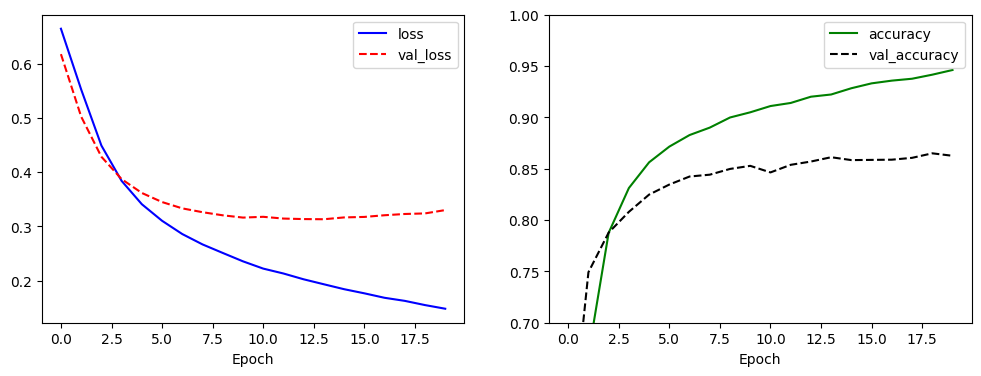

In [56]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_binary_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

## "실습" 과적합 방지

- 규제를 추가해 보자
- Earlystopping 을 추가해 보자

## 모델 내보내기

학습된 모델을 실제 추론(Inference) 단계에서 사용하기에 더 적합하고 독립적인 형태로 제공하기 위해서 학습한 모델이 새 데이터를 처리해 추론할 할 수 있도록 하려면  방금 훈련한 가중치를 사용하여 새 모델을 만들 수 있습니다.
 - vectorize_layer
    + 모델 학습 과정에서는 이미 텍스트가 정수 시퀀스(벡터화된 형태)로 변환된 상태
    + 그러므로 model 자체는 원시 텍스트를 직접 처리할 수 없어서 vectorizer 를 추가해 준다

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8541 - loss: 0.3849
0.8566799759864807


### 새로운 데이터로 추론하기

새로운 예에 대한 예측을 얻으려면 간단히 `model.predict()`를 호출하면 됩니다.

predict 를 하면 각 문장의 긍정 클래스 확률이 출력된다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


array([[0.38466096],
       [0.16048504],
       [0.10476626]], dtype=float32)

### 모델 저장과 탑재

여기서 저장은 SavedModel 형식(TensorFlow 2.x의 기본)으로  폴더에 모델의 구조와 가중치만 저장합니다.
 - 최신 kearas 3.x 에서는 SavedModel 형식으로 저장하려면 이제 model.export() 메서드를 사용

In [ ]:
# 1. 모델 저장 경로 설정


# 2. export_model 저장
# SavedModel 형식으로 저장하는 것이 권장됩니다.





INFO:tensorflow:Assets written to: models/imdb_entiment_model/assets


INFO:tensorflow:Assets written to: models/imdb_entiment_model/assets


Saved artifact at 'models/imdb_entiment_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.string, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132374743346512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132374743345360: TensorSpec(shape=(), dtype=tf.int64, name=None)
  132378415221456: TensorSpec(shape=(), dtype=tf.string, name=None)
  132374743342288: TensorSpec(shape=(), dtype=tf.int64, name=None)
  132374732997648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132374732999952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132374733001296: TensorSpec(shape=(), dtype=tf.resource, name=None)
모델 저장 완료.


Keras 3.0에서 SavedModel을 탑재시 keras.layers.TFSMLayer를 사용하여 SavedModel을 로드해야 합니다.

In [47]:
save_path

'models/imdb_entiment_model'

In [ ]:
# # 3. 저장된 모델 다시 불러오기
print(f"'{save_path}' 경로에서 모델을 불러오는 중입니다...")
# TFSMLayer를 사용하여 SavedModel을 로드합니다.
# call_endpoint는 SavedModel의 서빙 엔드포인트 이름이며, 기본적으로 'serving_default'입니다.


print("모델 불러오기 완료.")

'models/imdb_entiment_model' 경로에서 모델을 불러오는 중입니다...
모델 불러오기 완료.


In [ ]:
new_reviews = tf.constant([
    "This movie was absolutely fantastic! I loved every moment of it.",
    "It was okay, not great, not terrible.",
    "Worst film ever. A complete waste of time and money."
])

TFSMLayer는 모델처럼 직접 호출하거나 predict 메서드를 사용할 수 있습니다. TFSMLayer는 입력과 출력의 배치를 자동으로 처리합니다.


In [ ]:
print("\n불러온 모델로 예측 수행:")





불러온 모델로 예측 수행:


{'output_0': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.5398368 ],
        [0.10134336],
        [0.00645634]], dtype=float32)>}

In [52]:

# 결과 출력
print("예측 결과 (긍정 확률):")
for i, pred in enumerate(predictions['output_0']):
    review = new_reviews.numpy()[i].decode('utf-8')
    print(f"  리뷰: \"{review}\"")
    print(f"  예측 확률: {pred.numpy()[0]:.4f}") # tf.Tensor 값을 NumPy로 변환하여 출력
    if pred.numpy()[0] > 0.5:
        print("  -> 분류: 긍정")
    else:
        print("  -> 분류: 부정")
    print("-" * 30)

예측 결과 (긍정 확률):
  리뷰: "This movie was absolutely fantastic! I loved every moment of it."
  예측 확률: 0.5398
  -> 분류: 긍정
------------------------------
  리뷰: "It was okay, not great, not terrible."
  예측 확률: 0.1013
  -> 분류: 부정
------------------------------
  리뷰: "Worst film ever. A complete waste of time and money."
  예측 확률: 0.0065
  -> 분류: 부정
------------------------------


# "실습" Dense 층 추가

- 새 모델에 dense 레이어를 추가한다
   + dense 의 parameter 를 32, 8 로 테스트 해본다
   + dense 이후의 dropout 비율을 조절해 본다
- epochs 를 증가시키고 EarlyStopping 을 적용한다.

> GlobalAveragePooling1D 레이어가 Embedding 레이어의 출력을 직접 받아서 시퀀스 차원을 제거하고 각 샘플당 하나의 고정된 벡터를 만듭니다. 이 고정된 벡터에 Dense 레이어를 적용하는 것이 일반적입니다.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping





0epoch [00:00, ?epoch/s]

In [ ]:


print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - binary_accuracy: 0.7812 - loss: 0.6747

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8240 - loss: 0.4719
Loss:  0.47737032175064087
Accuracy:  0.8236799836158752


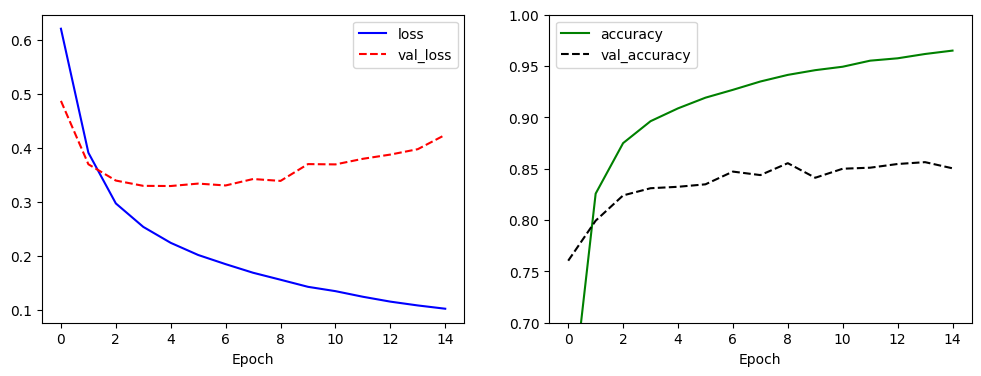

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], 'b-', label='loss')
plt.plot(history2.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['binary_accuracy'], 'g-', label='accuracy')
plt.plot(history2.history['val_binary_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

---

## 더 알아보기

이 튜토리얼은 텍스트 분류를 처음부터 알아보았습니다. 일반적인 텍스트 분류 워크플로에 대해 자세히 알아보려면 Google Developers의 [텍스트 분류 가이드](https://developers.google.com/machine-learning/guides/text-classification/)를 확인하세요.
